<a href="https://colab.research.google.com/github/dung18520632/NhanDien_CS338.L21/blob/main/Flask_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Tạo môi trường để sử dung Yolo
!pip install opencv-python==4.4.0.46 -i https://pypi.douban.com/simple

Looking in indexes: https://pypi.douban.com/simple
     |████████████████████████████████| 49.5MB 62kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [2]:
#Thư viện web trên colab
!pip install flask-ngrok

In [3]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Chỉ lấy label people
def load_network_1(config_file, data_file, weights, batch_size=1):
    network = load_net_custom(
        config_file.encode("ascii"),
        weights.encode("ascii"), 0, batch_size)
    metadata = load_meta(data_file.encode("ascii"))
    class_names = [metadata.names[i].decode("ascii") for i in range(1)]
    colors = class_colors(class_names)
    return network, class_names, colors

In [5]:
%cd /content/drive/MyDrive/darknet

/content/drive/MyDrive/darknet


In [6]:
#608X608
# load in our YOLOv4 architecture network
from darknet import *
network, class_names, class_colors = load_network_1("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)

In [7]:
#Hàm detection people
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [8]:
#Hiện thị ảnh Detection.(DÙNG ĐỂ TEST)
def Detection(detections,image):
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  cv2_imshow(image)

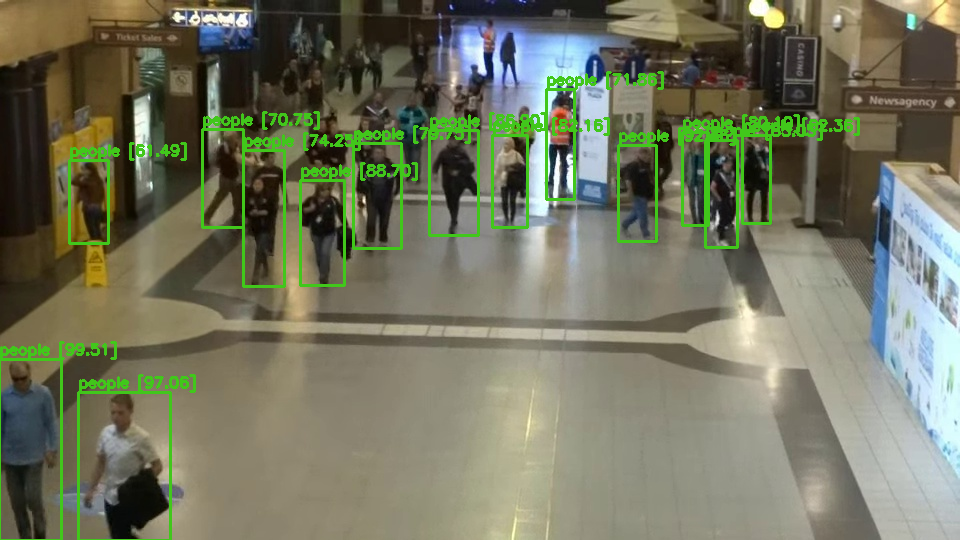

In [9]:
image = cv2.imread("/content/MOT20_02_raw_frame_100.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)
boxes = [bbox for _,_,bbox in detections]
Detection(detections,image)

In [10]:
original_image_BGR = cv2.imread('/content/MOT20_02_raw_frame_100.jpg')
original_image_RGB = cv2.cvtColor(original_image_BGR, cv2.COLOR_BGR2RGB)
image_width = original_image_RGB.shape[1]
image_height = original_image_RGB.shape[0]

original_image_BGR_copy = original_image_BGR.copy()
original_image_RGB_copy = original_image_RGB.copy()

print('image Shape', original_image_RGB.shape)

image Shape (540, 960, 3)


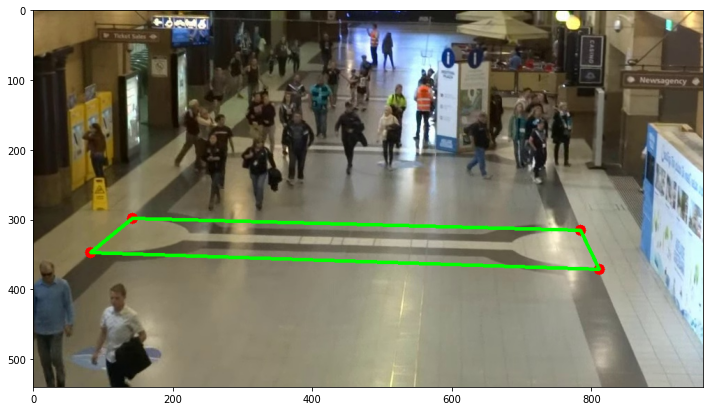

The perspective transform matrix:
[[ 4.64100594e+00  8.20914118e+00 -2.16714663e+03]
 [ 8.94136789e-02  2.14071423e+01 -1.19908691e+03]
 [ 3.12807115e-04  1.61722589e-02  1.00000000e+00]]


In [11]:
src = np.float32([[142., 298.],
                           [784., 315.],
                           [811., 371.],
                           [ 82., 347.]])
for point in src:
    cv2.circle(original_image_RGB_copy, tuple(point), 8, (255, 0, 0), -1)

points = src.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(original_image_RGB_copy, [points], True, (0,255,0), thickness=4)
plt.figure(figsize=(12, 12))
plt.imshow(original_image_RGB_copy)
plt.show()
dst=np.float32([(0.2,0.82), (0.80, 0.82), (0.80,0.87), (0.2,0.87)])

dst_size=(800,1080)
dst = dst * np.float32(dst_size)

H_matrix = cv2.getPerspectiveTransform(src, dst)
print("The perspective transform matrix:")
print(H_matrix)

In [12]:
#3 Point để tính distance pixel image so với thực tế
pts= np.float32([[[252., 314.],
                 [323., 316.],
                 [238., 347.]]])
warped_pt=cv2.perspectiveTransform(pts,H_matrix)[0]
#Point để tính distance pixel image so với thực tế
distance_w = np.sqrt((warped_pt[0][0] - warped_pt[1][0]) ** 2 + (warped_pt[0][1] - warped_pt[1][1]) ** 2)
distance_h = np.sqrt((warped_pt[0][0] - warped_pt[2][0]) ** 2 + (warped_pt[0][1] - warped_pt[2][1]) ** 2)

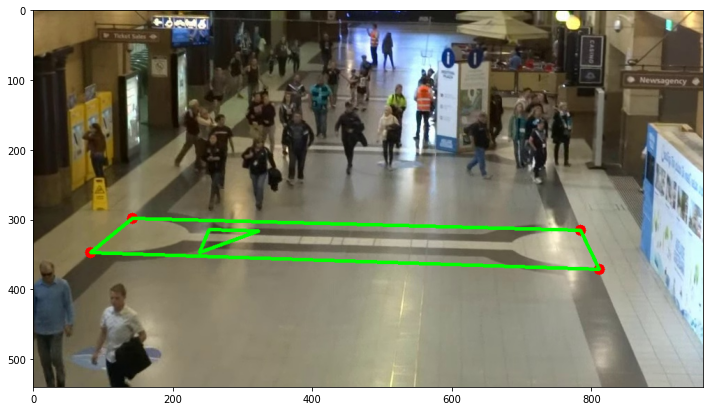

In [13]:
#Visualize
points_distance = pts.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(original_image_RGB_copy, [points_distance], True, (0,255,0), thickness=4)

plt.figure(figsize=(12, 12))
plt.imshow(original_image_RGB_copy)
plt.show()

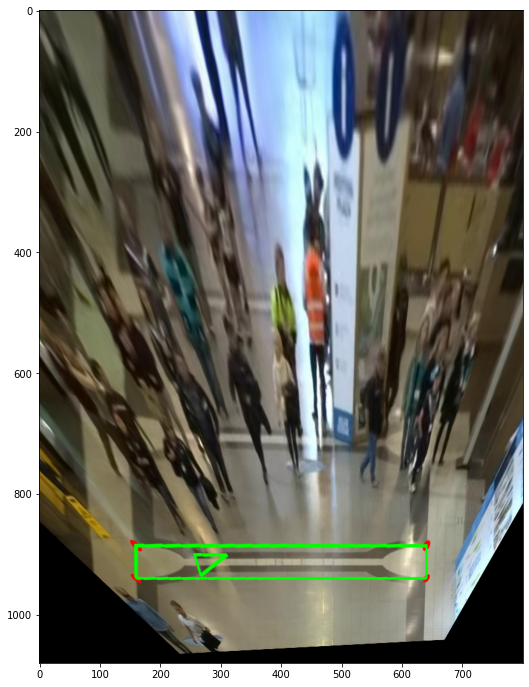

In [14]:
#Chuyển đổi matrix camera
warped = cv2.warpPerspective(original_image_RGB_copy, H_matrix, dst_size)
plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()

In [15]:
#Tính Position People sau khi chuyển đổi qua bird-eye 
def Point_transform(H_matrix,boxes):
      list_downoids = [[bbox[0],bbox[1]+bbox[3]//2] for bbox in boxes]
      list_points_to_detect=np.float32(list_downoids).reshape(-1,1,2)
      transformed_point=cv2.perspectiveTransform(list_points_to_detect,H_matrix)
      transformed_point_list= list()
      for i in range (0,transformed_point.shape[0]):
        transformed_point_list.append([transformed_point[i][0][0],transformed_point[i][0][1]])
      return np.array(transformed_point_list).astype('int')
birds_eye_points=Point_transform(H_matrix,boxes)

In [16]:
#Tính khoảng cách giữa 2 people
def eucledian_distance_1(point1, point2,distance_w, distance_h):
    x1,y1 = point1
    x2,y2 = point2
    h=abs(y2-y1)
    w=abs(x2-x1)
    dis_w = float((w/distance_w)*180)
    dis_h = float((h/distance_h)*180)
    
    return int(np.sqrt(((dis_h)**2) + ((dis_w)**2)))

In [17]:
#Hàm phát hiện khoảng cách có vi phạm blue(Không vi phạm) red(có vi phạm)
def get_red_green_boxes_1(distance_allowed,birds_eye_points,boxes,distance_w,distance_h):
    red_boxes = []
    green_boxes = []
    new_boxes = [tuple(box) + tuple(result) for box, result in zip(boxes, birds_eye_points)]
    for i in range(0, len(new_boxes)-1):
            for j in range(i+1, len(new_boxes)):
                cxi,cyi = new_boxes[i][4:]
                cxj,cyj = new_boxes[j][4:]
                distance = eucledian_distance_1([cxi,cyi], [cxj,cyj],distance_w, distance_h)
                if distance < distance_allowed:
                    red_boxes.append(new_boxes[i])
                    red_boxes.append(new_boxes[j])
    green_boxes = list(set(new_boxes) - set(red_boxes))
    red_boxes = list(set(red_boxes))

    return (green_boxes, red_boxes)

In [20]:
min_distance = 120
green_box,red_box=get_red_green_boxes_1(min_distance,birds_eye_points,boxes,distance_w,distance_h)

In [21]:
#Chuyển đổi qua rectangle để draw
def convertBack(x, y, w, h): 
    xmin = int(round(x - (w / 2)))
    xmax = int(round(x + (w / 2)))
    ymin = int(round(y - (h / 2)))
    ymax = int(round(y + (h / 2)))
    return xmin, ymin, xmax, ymax

In [22]:
#Draw
def get_red_green_box_image(new_box_image,green_box,red_box,width_ratio,height_ratio):
    for point in green_box:
        xmin, ymin, xmax, ymax = convertBack(point[0], point[1], point[2],point[3])
        xmin, ymin, xmax, ymax = int(xmin * width_ratio), int(ymin * height_ratio), int(xmax * width_ratio), int(ymax * height_ratio)
        cv2.rectangle(new_box_image,(xmin,ymin),(xmax,ymax),(0, 255, 0), 2)
    for point in red_box:
        xmin, ymin, xmax, ymax = convertBack(point[0], point[1], point[2],point[3])
        xmin, ymin, xmax, ymax = int(xmin * width_ratio), int(ymin * height_ratio), int(xmax * width_ratio), int(ymax * height_ratio)
        cv2.rectangle(new_box_image,(xmin,ymin),(xmax,ymax),(0, 0, 255), 2)
    return new_box_image

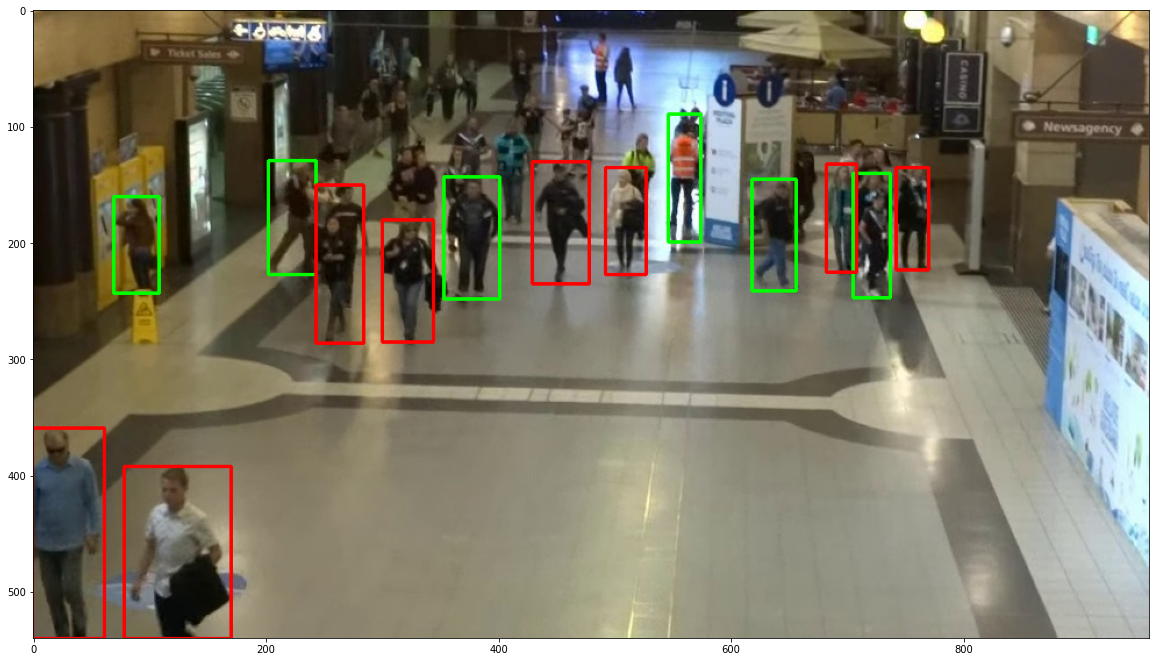

In [23]:
box_red_green_image = get_red_green_box_image(original_image_BGR.copy(),green_box,red_box,width_ratio,height_ratio)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(box_red_green_image, cv2.COLOR_RGB2BGR))
plt.show()

In [24]:
#Chuyển đổi lên map bird-eye-view
def get_birds_eye_view_image(green_box, red_box,eye_view_height,eye_view_width):
    blank_image = cv2.imread('/content/black_background.png')
    
    cv2.putText(blank_image, str(len(red_box)), (120,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,0,255), 4, cv2.LINE_AA) 
    cv2.putText(blank_image, str(len(green_box)), (520,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), 4, cv2.LINE_AA)
    
    for point in green_box:
        cv2.circle(blank_image,tuple([point[4],point[5]]),20,(0,255,0),-1)
    for point in red_box:
        cv2.circle(blank_image,tuple([point[4],point[5]]),20,(0,0,255),-1)
    blank_image = cv2.resize(blank_image,(eye_view_width,eye_view_height))
    return blank_image

In [25]:
birds_eye_view_image = get_birds_eye_view_image(green_box, red_box,eye_view_height=image_height,eye_view_width=image_width//2)

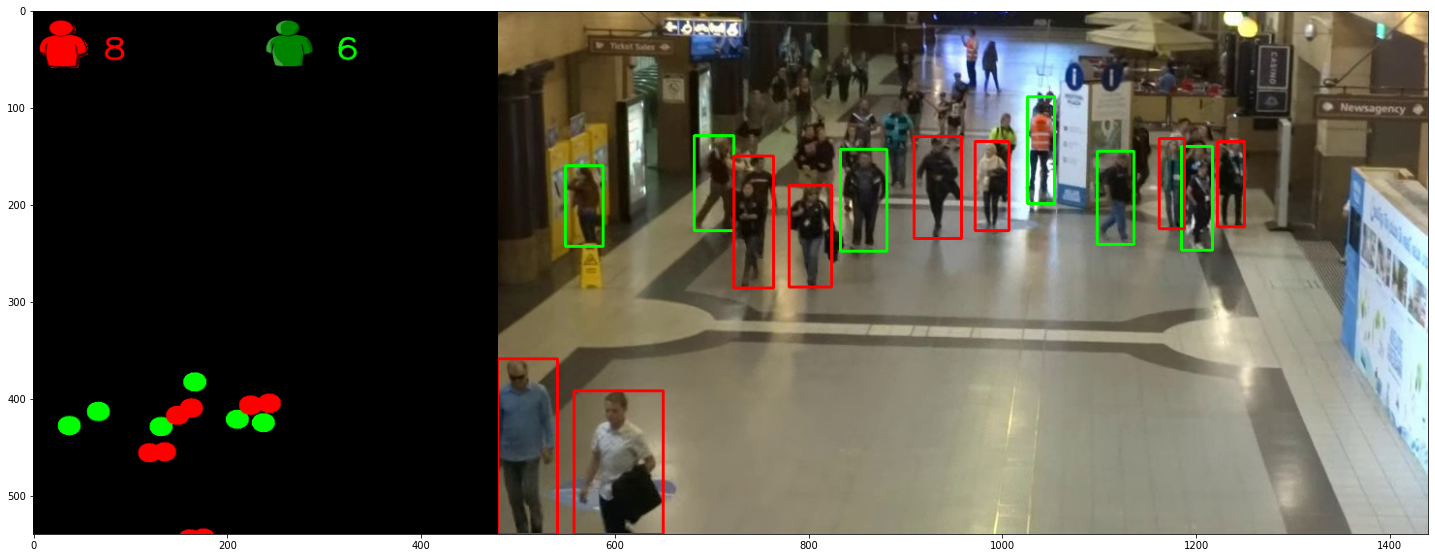

In [26]:
#Nối 2 ảnh đã handle
combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
plt.figure(figsize=(25, 20))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))
plt.show()

In [30]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, Response
import cv2
import sys
from imutils.video import FPS
from imutils.video import FileVideoStream

app=Flask(__name__,template_folder="/content/templates")
run_with_ngrok(app)

@app.route('/')
def index():
    """Video streaming home page."""
    return render_template('index.html')
H_matrix_flask=H_matrix
distance_h_flask=distance_h
distance_w_flask=distance_w
width_flask=width
height_flask=height
image_height_flask=image_height
image_width_flask=image_width
video = FileVideoStream('/content/People2_Trim.mp4').start()
def gen(H_matrix_flask,distance_w_flask,distance_h_flask,width_flask,height_flask,image_height_flask,image_width_flask):
    frame_number = 0
    print('%-20s%-26s%-26s%-26s' % ('Processing Frame','|Total Detected Person','|Red Markerd Person','|Green Marked Person'))
    """Video streaming generator function."""
    # Read until video is completed
    min_distance=180
    while video.more():
        frame = video.read()
        detections, width_ratio, height_ratio = darknet_helper(frame, width_flask, height_flask)
        boxes = [bbox for _,_,bbox in detections]
        birds_eye_points = Point_transform(H_matrix_flask, boxes)
        green_box, red_box = get_red_green_boxes_1(min_distance, birds_eye_points,boxes,distance_w_flask,distance_h_flask)
        birds_eye_view_image = get_birds_eye_view_image(green_box, red_box, eye_view_height=image_height_flask,eye_view_width=image_width_flask//2)
        box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box,width_ratio,height_ratio)

        combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
          
        frame = cv2.imencode('.jpg', combined_image)[1].tobytes()
        yield (b'--frame\r\n'b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')
        del detections,combined_image,birds_eye_view_image
        #time.sleep(0.1)
        # del detections,combined_image,birds_eye_view_image
        key = cv2.waitKey(30)
        if key == 27:
           break   
@app.route('/video_feed')
def video_feed():
    """Video streaming route. Put this in the src attribute of an img tag."""
    return Response(gen(H_matrix_flask,distance_w_flask,distance_h_flask,width_flask,height_flask,image_height_flask,image_width_flask),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://54916c6753ef.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [08/Jun/2021 06:54:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Jun/2021 06:54:47] "GET /video_feed HTTP/1.1" 200 -


Processing Frame    |Total Detected Person    |Red Markerd Person       |Green Marked Person      


127.0.0.1 - - [08/Jun/2021 06:54:48] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
import sys
video = cv2.VideoCapture('/content/People2_Trim.mp4')
writer = None
frame_number = 0
print('%-20s%-26s%-26s%-26s' % ('Processing Frame','|Total Detected Person','|Red Markerd Person','|Green Marked Person'))
while True:
  
  ret,frame = video.read()

  if not ret:
    break
  detections, width_ratio, height_ratio = darknet_helper(frame, width, height)
  boxes = [bbox for _,_,bbox in detections]
  birds_eye_points = Point_transform(H_matrix, boxes)
  green_box, red_box = get_red_green_boxes_1(min_distance, birds_eye_points,boxes,distance_w,distance_h)
  birds_eye_view_image = get_birds_eye_view_image(green_box, red_box, eye_view_height=image_height,eye_view_width=image_width//2)
  box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box,width_ratio,height_ratio)

  combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)

  frame_number += 1
  sys.stdout.write('%-20i|%-25i|%-25i|%-25i\n' % (frame_number,len(boxes),len(red_box),len(green_box)))

  # if frame_number >=20:
  #   break

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    writer = cv2.VideoWriter('/content/test.avi', fourcc, 15, (combined_image.shape[1], combined_image.shape[0]), True)

  writer.write(combined_image)

  del detections,combined_image,birds_eye_view_image

print(' ')
writer.release()
video.release()

Processing Frame    |Total Detected Person    |Red Markerd Person       |Green Marked Person      
1                   |17                       |8                        |9                        
2                   |17                       |10                       |7                        
3                   |17                       |10                       |7                        
4                   |17                       |10                       |7                        
5                   |17                       |10                       |7                        
6                   |18                       |10                       |8                        
7                   |18                       |10                       |8                        
8                   |20                       |10                       |10                       
9                   |20                       |12                       |8                        
10        

KeyboardInterrupt: ignored